<h1>Importing Libraries</h1>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as ag
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau

<h1> Solution to Lane Emden Equation </h1>

<p> Ignoring at x = 0 (as it is a singularity) </p>

In [ ]:
def solution(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        y = np.where(x == 0, 1, np.sin(x) / x)
    return y

<h1>Neural Network Architecture</h1>

<p>Defining the Neural Network Class, which will be called multiple times throughout the program</p>

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int = 1, output_size: int = 1, hidden_layers: int = 5, hidden_nodes: int = 10) -> None:
        super().__init__()

        self.inputs  = nn.Linear(input_size, hidden_nodes)
        self.model   = nn.ModuleList([nn.Linear(hidden_nodes, hidden_nodes)] * hidden_layers)
        self.outputs = nn.Linear(hidden_nodes, output_size)

        self.activation = nn.Tanh()

    def _apply_model(self, x: torch.Tensor) -> torch.Tensor:
      for layer in self.model:
          x = self.activation(layer(x))
      return x

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.activation(self.inputs(t))
        t = self._apply_model(t)
        t = self.outputs(t)
        return t

<h1>Generate Training Data</h1>

<h2> Defining Function to Create training points, with number of collocation points as an argument </h2>

In [ ]:
def create_training_points(no_colloc_points):
  x = np.linspace(0, 7, 700).reshape(-1, 1)  # Training Points
  y = solution(x).reshape(-1, 1)

  x_data = x[0:300:30] # Reducing the training points
  y_data = y[0:300:30]

  x_data = torch.tensor(x_data, dtype=torch.float32)
  y_data = torch.tensor(y_data, dtype=torch.float32)

  x_physics = torch.linspace(0, 7, no_colloc_points, requires_grad=True, dtype=torch.float32).reshape(-1, 1) # Collocation Points
  return x_data, y_data, x_physics


<h1>Hyperparameters and Training (Without Physics Loss)</h1>

In [ ]:
EPOCHS = 20000
LR = 3e-3

model = NeuralNetwork(hidden_layers = 1, hidden_nodes = 32)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()
x_data,y_data,x_physics = create_training_points(20)

for epoch in range(EPOCHS):
  optim.zero_grad()

  y_pred = model(x_data)   #Predicting training data
  loss_y = data_loss(y_pred,y_data) # Calulating normal MSE Loss

  loss = loss_y

  loss.backward()
  optim.step()
  scheduler.step(loss)

  if epoch % 1000 == 0:
    print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")


Epochs = 0 of 20000, Loss = 7.3437e-01
Epochs = 1000 of 20000, Loss = 6.7068e-07
Epochs = 2000 of 20000, Loss = 3.1010e-07
Epochs = 3000 of 20000, Loss = 2.5977e-07
Epochs = 4000 of 20000, Loss = 2.1174e-07
Epochs = 5000 of 20000, Loss = 4.4658e-06
Epochs = 6000 of 20000, Loss = 4.6824e-06
Epochs = 7000 of 20000, Loss = 7.7766e-08
Epochs = 8000 of 20000, Loss = 4.1813e-08
Epochs = 9000 of 20000, Loss = 5.5589e-07
Epochs = 10000 of 20000, Loss = 4.6569e-08
Epochs = 11000 of 20000, Loss = 5.4054e-09
Epochs = 12000 of 20000, Loss = 2.3861e-06
Epochs = 13000 of 20000, Loss = 2.1837e-06
Epochs = 14000 of 20000, Loss = 4.6629e-09
Epoch 14180: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 15000 of 20000, Loss = 4.5331e-09
Epoch 15181: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 16000 of 20000, Loss = 4.2219e-09
Epoch 16182: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 17000 of 20000, Loss = 4.1858e-09
Epoch 17183: reducing learning rate of group 0 to 3.0

In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().numpy().reshape(-1,1)

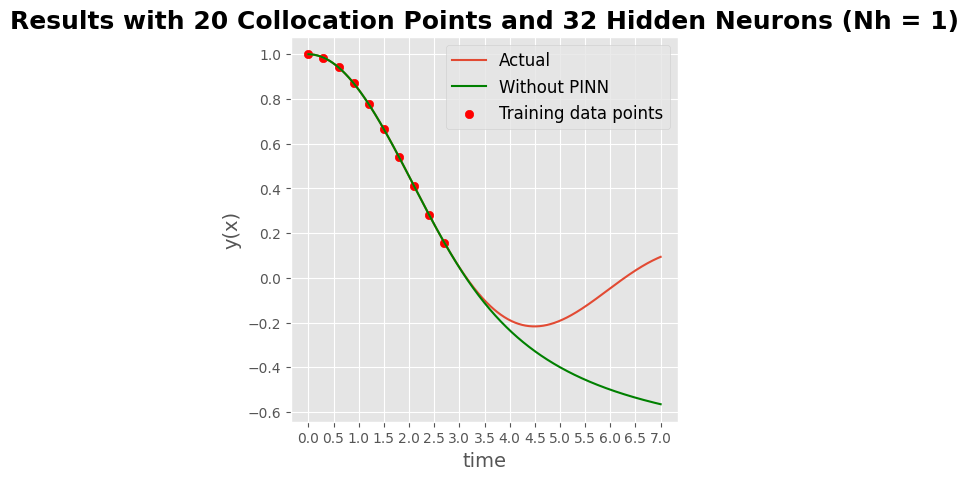

In [ ]:
title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
}

plt.figure(figsize=(5, 5))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 7.5, step=0.5))
plt.title("Results with 20 Collocation Points and 32 Hidden Neurons (Nh = 1)", title_font)
plt.plot(x, y, label="Actual")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="Without PINN", c="g")
plt.ylabel("y(x)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
plt.legend(fontsize="large")
plt.show()

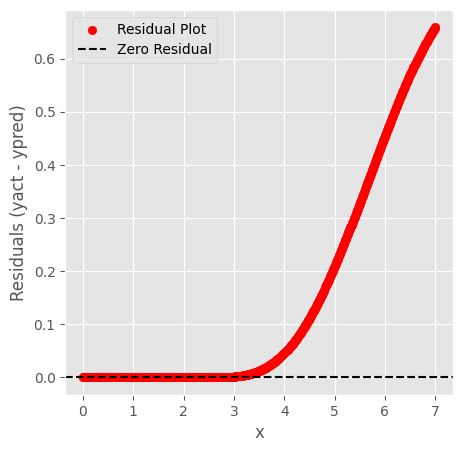

In [ ]:
residuals = y - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(x, residuals, color='r', label='Residual Plot')
plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
plt.xlabel('x')
plt.ylabel('Residuals (yact - ypred)')
plt.legend()
plt.show()

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

0.06476038119832109


<h1>Hyperparamters and Training (With Physics Loss)<h1>

<h1> Defining PINN Model<h1>

In [ ]:
def create_pinn_model(no_hidden_layer,no_hidden_node,no_of_colloc):
  EPOCHS = 20000
  LR = 3e-3

  model = NeuralNetwork(hidden_layers=no_hidden_layer, hidden_nodes=no_hidden_node)
  optim = torch.optim.Adam(model.parameters(),lr=LR)
  scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
  data_loss = nn.MSELoss()
  x_data, y_data, x_physics = create_training_points(no_of_colloc)

  for epoch in range(EPOCHS):
      optim.zero_grad()

      # Compute the "data loss"
      y_pred = model(x_data)
      loss_y = data_loss(y_pred, y_data)

      # Compute the Derivates of the model WRT inputs
      u   = model(x_physics)
      du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
      ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

      # BC condition on x=0
      loss_y=loss_y + 0.01*(du[0]**2)

      # Compute the physics loss
      physics = x_physics*ddu + 2*du + u*x_physics
      loss_f = torch.mean(physics**2)

      # backpropagate joint loss
      loss = loss_y + loss_f # add two loss terms together with equal weight
      loss.backward()
      optim.step()
      scheduler.step(loss)

      if epoch % 1000 == 0:
          print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")
  return model

In [ ]:
model = create_pinn_model(1,32,20)

Epochs = 0 of 20000, Loss = 1.0506e+00
Epochs = 1000 of 20000, Loss = 2.4542e-03
Epochs = 2000 of 20000, Loss = 5.3986e-04
Epochs = 3000 of 20000, Loss = 1.5890e-04
Epochs = 4000 of 20000, Loss = 3.5012e-05
Epochs = 5000 of 20000, Loss = 1.8550e-05
Epochs = 6000 of 20000, Loss = 1.9883e-05
Epoch 06762: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 7000 of 20000, Loss = 1.9552e-05
Epoch 07763: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 8000 of 20000, Loss = 1.8359e-05
Epoch 08764: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 9000 of 20000, Loss = 1.8184e-05
Epoch 09765: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 10000 of 20000, Loss = 1.8158e-05
Epoch 10766: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 11000 of 20000, Loss = 1.8157e-05
Epoch 11767: reducing learning rate of group 0 to 3.0000e-09.
Epochs = 12000 of 20000, Loss = 1.8157e-05
Epochs = 13000 of 20000, Loss = 1.8157e-05
Epochs = 14000 of 20000, Loss = 1.8157e

In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(no_of_colloc)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.946287582543071e-08


In [ ]:
def create_graph_1(no_colloc_points,no_of_neuron,no_of_hidden_layer,x,x_data,y,y_data,y_prediction):

  title_font = {
      "fontsize" : 18,
      "fontweight": "bold"
  }

  plt.figure(figsize=(5, 5))
  plt.style.use("ggplot")
  plt.xticks(np.arange(0, 7.5, step=0.5))
  plt.title(f"{no_colloc_points} Collocation Points,{no_of_neuron} Neurons each in {no_of_hidden_layer} hidden layer", title_font)
  plt.plot(x, y, label="Actual")
  plt.xlabel("time", fontsize=14)
  plt.plot(x, y_prediction, label="PINN", c="g")
  plt.ylabel("u(t)", fontsize=14)
  plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
  plt.legend(fontsize="large")
  plt.show()

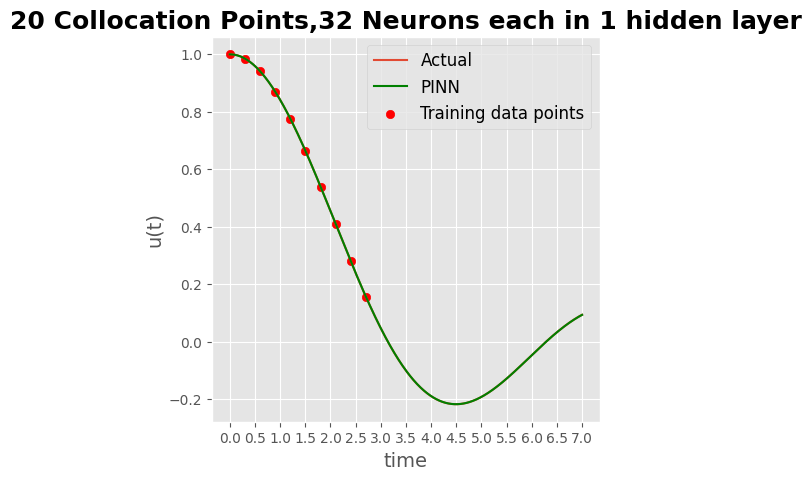

In [ ]:
create_graph_1(20,32,1,x,x_data,y,y_data,y_pred)

In [ ]:
def create_graph_2(x,y_prediction):
  residuals = y - y_prediction
  plt.figure(figsize=(5, 5))
  plt.scatter(x, residuals, color='r', label='Residual Plot')
  plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
  plt.xlabel('x')
  plt.ylabel('Residuals (yact - ypred)')
  plt.legend()
  plt.show()

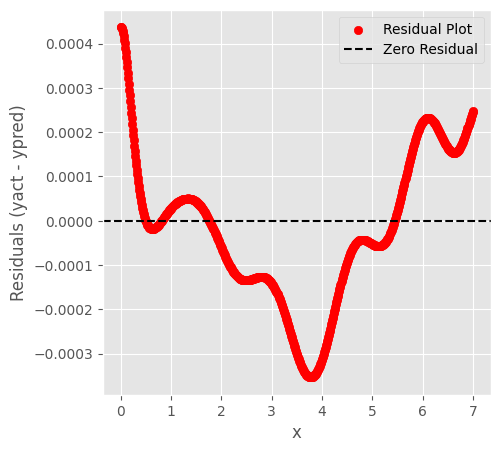

In [ ]:
create_graph_2(x,y_pred)

<h1> From the above results, PINNs obviously generate better results when dealing with differential equations, however we can also analyse the effect of architecture on results of PINNs<h1>



<h1> 2. Varying the number of neurons in each layer

<h1> 2.1 Nh = 1, N = 16, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,16,20)

Epochs = 0 of 20000, Loss = 1.1877e+00
Epochs = 1000 of 20000, Loss = 6.6315e-04
Epochs = 2000 of 20000, Loss = 3.9105e-04
Epochs = 3000 of 20000, Loss = 2.7880e-05
Epochs = 4000 of 20000, Loss = 2.3864e-05
Epochs = 5000 of 20000, Loss = 2.1253e-05
Epochs = 6000 of 20000, Loss = 1.9272e-05
Epochs = 7000 of 20000, Loss = 1.7299e-05
Epochs = 8000 of 20000, Loss = 1.6251e-05
Epochs = 9000 of 20000, Loss = 1.4556e-05
Epochs = 10000 of 20000, Loss = 1.2790e-05
Epochs = 11000 of 20000, Loss = 1.1537e-05
Epochs = 12000 of 20000, Loss = 2.0062e-05
Epochs = 13000 of 20000, Loss = 1.1384e-05
Epochs = 14000 of 20000, Loss = 9.3162e-06
Epochs = 15000 of 20000, Loss = 8.2534e-06
Epochs = 16000 of 20000, Loss = 1.5619e-05
Epochs = 17000 of 20000, Loss = 6.9507e-06
Epochs = 18000 of 20000, Loss = 5.8656e-06
Epochs = 19000 of 20000, Loss = 5.4065e-06


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

5.327446387710545e-07


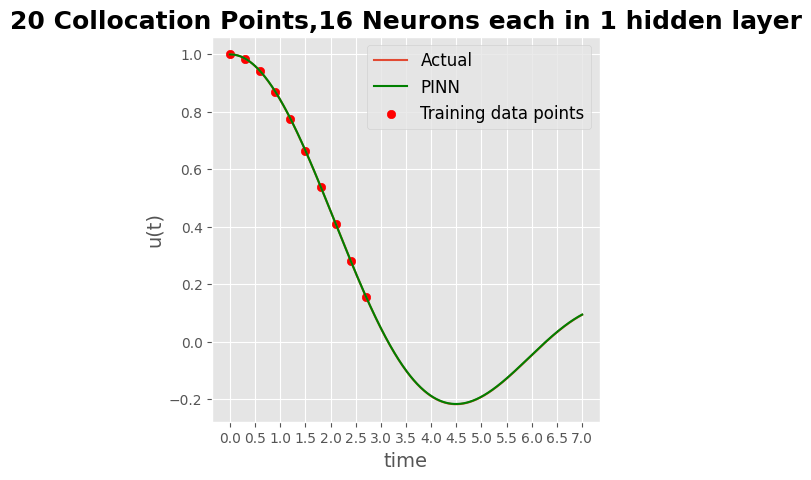

In [ ]:
create_graph_1(20,16,1,x,x_data,y,y_data,y_pred)

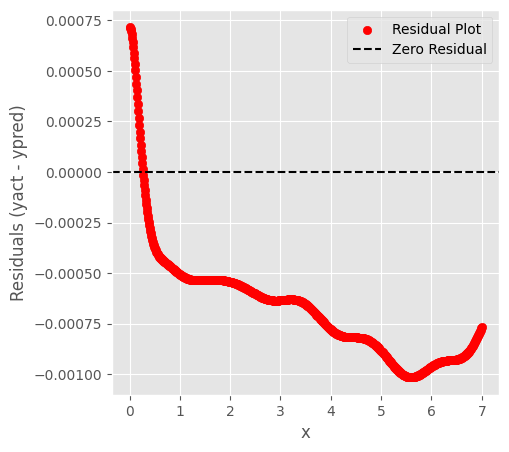

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.2 Nh = 1, N = 20, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,20,20)

Epochs = 0 of 20000, Loss = 1.3685e+00
Epochs = 1000 of 20000, Loss = 7.2657e-03
Epochs = 2000 of 20000, Loss = 7.4337e-04
Epochs = 3000 of 20000, Loss = 9.1085e-03
Epochs = 4000 of 20000, Loss = 2.5663e-04
Epochs = 5000 of 20000, Loss = 1.3231e-04
Epochs = 6000 of 20000, Loss = 6.7787e-05
Epochs = 7000 of 20000, Loss = 4.9159e-05
Epochs = 8000 of 20000, Loss = 4.0574e-05
Epochs = 9000 of 20000, Loss = 6.6804e-05
Epochs = 10000 of 20000, Loss = 2.3960e-05
Epochs = 11000 of 20000, Loss = 2.6450e-05
Epochs = 12000 of 20000, Loss = 4.2178e-03
Epochs = 13000 of 20000, Loss = 1.7787e-05
Epochs = 14000 of 20000, Loss = 1.9645e-05
Epochs = 15000 of 20000, Loss = 1.3394e-05
Epochs = 16000 of 20000, Loss = 1.3813e-05
Epochs = 17000 of 20000, Loss = 1.9142e-05
Epochs = 18000 of 20000, Loss = 1.4658e-05
Epochs = 19000 of 20000, Loss = 7.9611e-06


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.455681358444268e-08


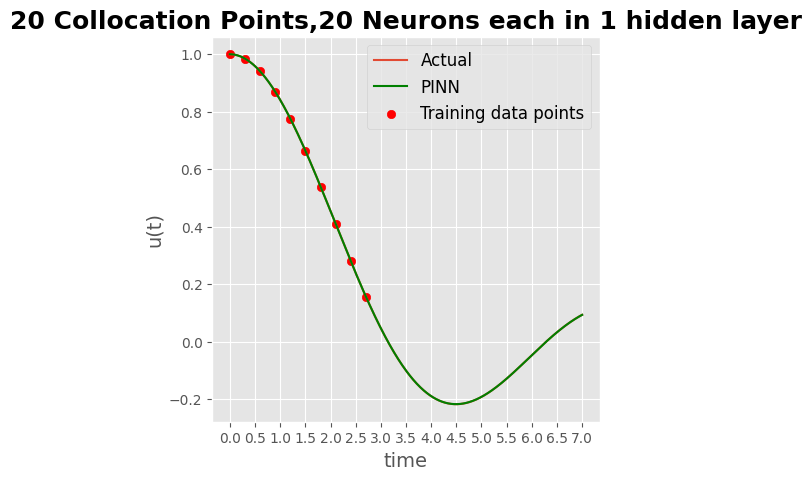

In [ ]:
create_graph_1(20,20,1,x,x_data,y,y_data,y_pred)

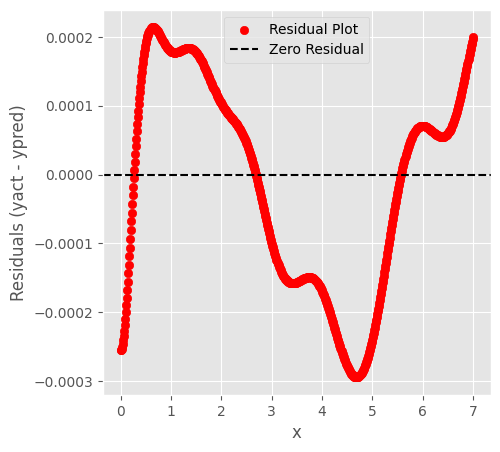

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.3 Nh = 1, N = 24, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,24,20)

Epochs = 0 of 20000, Loss = 2.9491e+00
Epochs = 1000 of 20000, Loss = 8.2687e-03
Epochs = 2000 of 20000, Loss = 1.9247e-03
Epochs = 3000 of 20000, Loss = 1.7930e-04
Epochs = 4000 of 20000, Loss = 1.0281e-04
Epochs = 5000 of 20000, Loss = 8.9253e-05
Epochs = 6000 of 20000, Loss = 6.2952e-05
Epochs = 7000 of 20000, Loss = 4.0042e-05
Epochs = 8000 of 20000, Loss = 3.3978e-05
Epochs = 9000 of 20000, Loss = 3.2391e-05
Epochs = 10000 of 20000, Loss = 3.3927e-05
Epochs = 11000 of 20000, Loss = 1.4264e-05
Epochs = 12000 of 20000, Loss = 1.1746e-05
Epochs = 13000 of 20000, Loss = 9.4222e-06
Epochs = 14000 of 20000, Loss = 8.3170e-06
Epochs = 15000 of 20000, Loss = 7.0628e-06
Epochs = 16000 of 20000, Loss = 1.2083e-05
Epochs = 17000 of 20000, Loss = 1.5870e-04
Epochs = 18000 of 20000, Loss = 2.2726e-05
Epochs = 19000 of 20000, Loss = 4.1922e-06


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.7053212988187934e-09


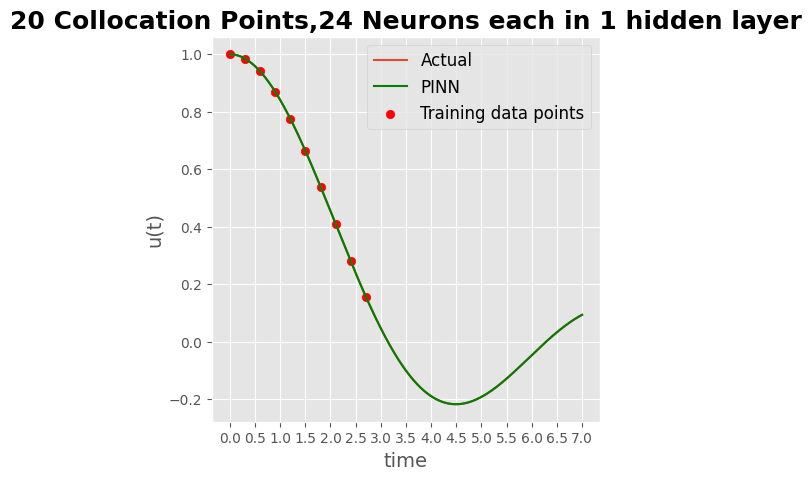

In [ ]:
create_graph_1(20,24,1,x,x_data,y,y_data,y_pred)

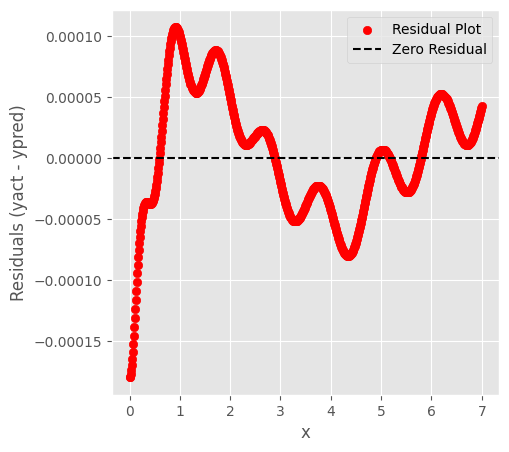

In [ ]:
create_graph_2(x,y_pred)

<h1> 2.4 Nh = 1, N = 28, Nc= 20 </h1>

In [ ]:
model = create_pinn_model(1,28,20)

Epochs = 0 of 20000, Loss = 2.5570e+00
Epochs = 1000 of 20000, Loss = 1.1023e-02
Epochs = 2000 of 20000, Loss = 1.3623e-03
Epochs = 3000 of 20000, Loss = 9.8819e-05
Epochs = 4000 of 20000, Loss = 5.2940e-05
Epochs = 5000 of 20000, Loss = 4.9153e-05
Epochs = 6000 of 20000, Loss = 7.9651e-04
Epochs = 7000 of 20000, Loss = 3.7864e-05
Epochs = 8000 of 20000, Loss = 2.8402e-05
Epochs = 9000 of 20000, Loss = 2.3193e-05
Epochs = 10000 of 20000, Loss = 1.8248e-05
Epochs = 11000 of 20000, Loss = 1.3508e-05
Epochs = 12000 of 20000, Loss = 8.5458e-05
Epochs = 13000 of 20000, Loss = 9.1490e-06
Epochs = 14000 of 20000, Loss = 8.2747e-06
Epochs = 15000 of 20000, Loss = 4.2497e-05
Epochs = 16000 of 20000, Loss = 8.3573e-06
Epochs = 17000 of 20000, Loss = 5.5405e-06
Epochs = 18000 of 20000, Loss = 2.3242e-04
Epochs = 19000 of 20000, Loss = 4.6459e-06


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

4.4787253478173595e-07


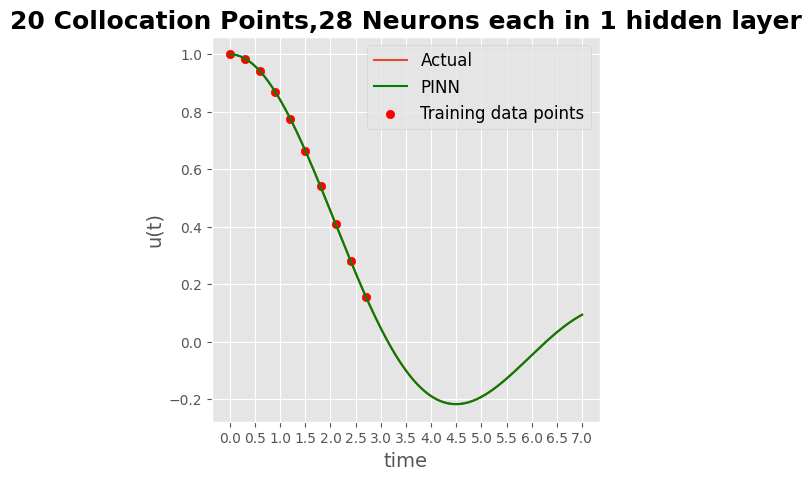

In [ ]:
create_graph_1(20,28,1,x,x_data,y,y_data,y_pred)

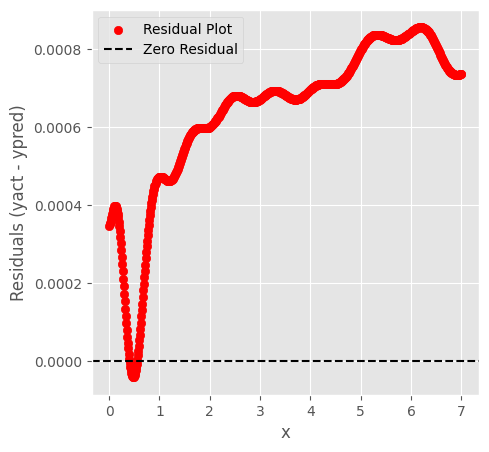

In [ ]:
create_graph_2(x,y_pred)

<h1>2.5 Conclusion</h1>

20 Collocation points, 1 Hidden Layer:

<ul>
<li>16 Neurons: 5.327446387710545e-07</li>
<li>20 Neurons: 2.455681358444268e-08</li>
<li>24 Neurons: 2.7053212988187934e-09</li>
<li>28 Neurons: 4.4787253478173595e-07</li>
</ul>

Therefore, 24 neurons seems to the better option. So we'll continue with 24 Neurons

<h1> 3. Varying the number of collocation points </h1>

<h1>3.1 Nh = 1, N = 24, Nc= 10<h1>

In [ ]:
model = create_pinn_model(1,24,10)

Epochs = 0 of 20000, Loss = 1.5014e+00
Epochs = 1000 of 20000, Loss = 1.2603e-02
Epochs = 2000 of 20000, Loss = 1.4316e-05
Epochs = 3000 of 20000, Loss = 5.4681e-07
Epochs = 4000 of 20000, Loss = 3.3935e-07
Epochs = 5000 of 20000, Loss = 9.3423e-07
Epochs = 6000 of 20000, Loss = 2.8412e-04
Epochs = 7000 of 20000, Loss = 5.9164e-05
Epochs = 8000 of 20000, Loss = 1.9678e-08
Epochs = 9000 of 20000, Loss = 1.5436e-08
Epochs = 10000 of 20000, Loss = 1.1157e-06
Epoch 10042: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 11000 of 20000, Loss = 1.9204e-08
Epoch 11043: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 12000 of 20000, Loss = 1.8338e-08
Epoch 12044: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 13000 of 20000, Loss = 1.8238e-08
Epoch 13045: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 14000 of 20000, Loss = 1.8233e-08
Epoch 14046: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 15000 of 20000, Loss = 1.8229e-08
Epoch 15047: re

In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.9872757342093745e-08


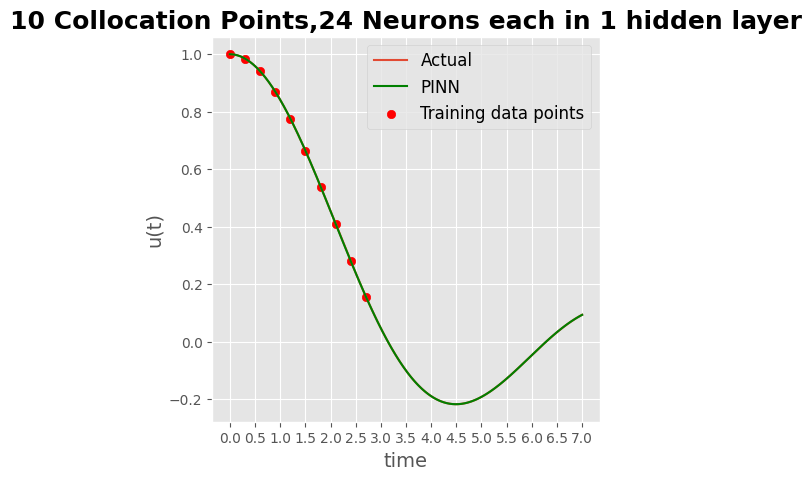

In [ ]:
create_graph_1(10,24,1,x,x_data,y,y_data,y_pred)

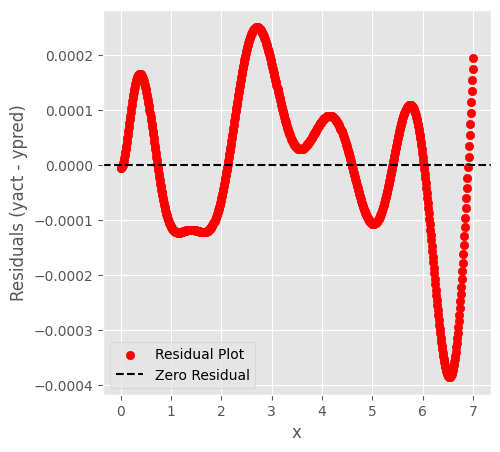

In [ ]:
create_graph_2(x,y_pred)

<h1>3.2 Nh = 1, N = 24, Nc= 15<h1>

In [ ]:
model = create_pinn_model(1,24,15)

Epochs = 0 of 20000, Loss = 5.5157e-01
Epochs = 1000 of 20000, Loss = 1.1613e-02
Epochs = 2000 of 20000, Loss = 1.1692e-03
Epochs = 3000 of 20000, Loss = 5.6599e-04
Epochs = 4000 of 20000, Loss = 3.1298e-04
Epochs = 5000 of 20000, Loss = 2.0510e-04
Epochs = 6000 of 20000, Loss = 1.4661e-04
Epochs = 7000 of 20000, Loss = 9.9031e-05
Epochs = 8000 of 20000, Loss = 6.7869e-05
Epochs = 9000 of 20000, Loss = 4.1283e-05
Epochs = 10000 of 20000, Loss = 2.4073e-05
Epochs = 11000 of 20000, Loss = 1.2859e-05
Epochs = 12000 of 20000, Loss = 4.4054e-04
Epochs = 13000 of 20000, Loss = 4.7221e-06
Epochs = 14000 of 20000, Loss = 3.5610e-06
Epochs = 15000 of 20000, Loss = 3.5756e-06
Epochs = 16000 of 20000, Loss = 4.6342e-06
Epochs = 17000 of 20000, Loss = 2.8304e-06
Epoch 17374: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 18000 of 20000, Loss = 2.8947e-06
Epoch 18375: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 19000 of 20000, Loss = 2.7787e-06
Epoch 19376: reducing learnin

In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

2.9754251113567395e-08


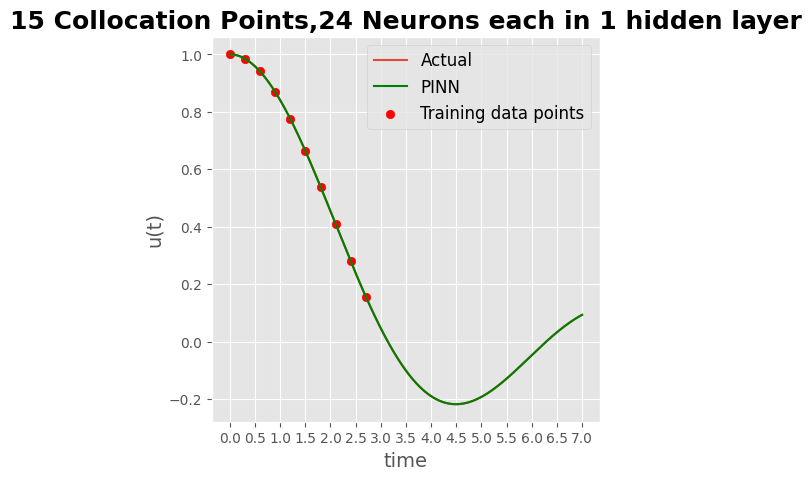

In [ ]:
create_graph_1(15,24,1,x,x_data,y,y_data,y_pred)

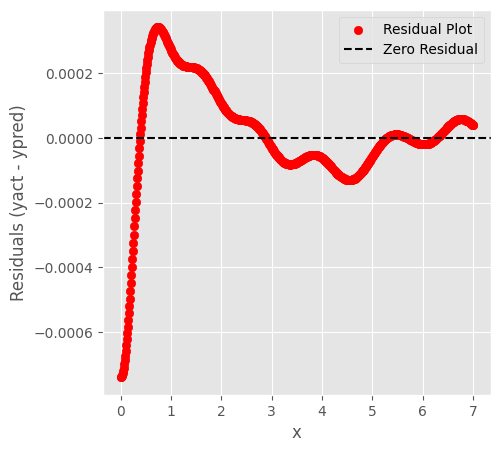

In [ ]:
create_graph_2(x,y_pred)

<h1>3.3 Nh = 1, N = 24, Nc= 25<h1>

In [ ]:
model = create_pinn_model(1,24,25)

Epochs = 0 of 20000, Loss = 4.6761e+00
Epochs = 1000 of 20000, Loss = 7.0122e-03
Epochs = 2000 of 20000, Loss = 6.0294e-04
Epochs = 3000 of 20000, Loss = 2.7806e-04
Epochs = 4000 of 20000, Loss = 1.8312e-04
Epochs = 5000 of 20000, Loss = 1.3397e-04
Epochs = 6000 of 20000, Loss = 1.0399e-04
Epochs = 7000 of 20000, Loss = 8.9269e-05
Epochs = 8000 of 20000, Loss = 7.1566e-05
Epochs = 9000 of 20000, Loss = 6.2181e-05
Epochs = 10000 of 20000, Loss = 4.3986e-05
Epochs = 11000 of 20000, Loss = 3.3299e-05
Epochs = 12000 of 20000, Loss = 2.7477e-05
Epochs = 13000 of 20000, Loss = 2.1520e-05
Epochs = 14000 of 20000, Loss = 1.7155e-05
Epochs = 15000 of 20000, Loss = 1.2846e-05
Epochs = 16000 of 20000, Loss = 9.5057e-06
Epochs = 17000 of 20000, Loss = 2.7878e-05
Epochs = 18000 of 20000, Loss = 5.3963e-06
Epochs = 19000 of 20000, Loss = 2.4235e-04


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

4.957080298011296e-07


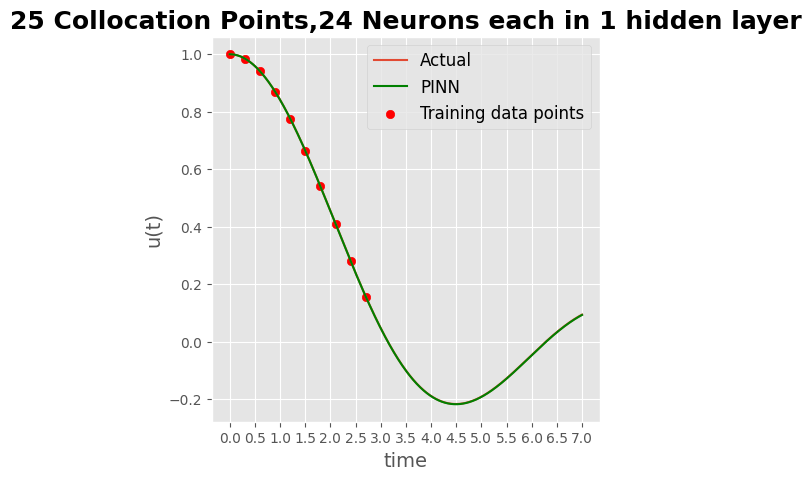

In [ ]:
create_graph_1(25,24,1,x,x_data,y,y_data,y_pred)

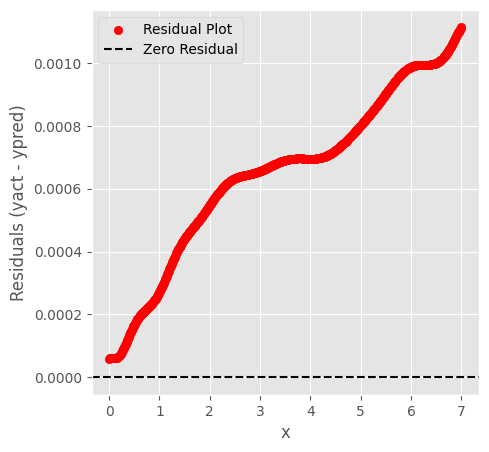

In [ ]:
create_graph_2(x,y_pred)

<h1>3.4 Conclusion </h1>


24 Neurons, 1 Hidden Layer:

<ul>
<li>10 Neurons: 1.9872757342093745e-08</li>
<li>15 Neurons: 2.9754251113567395e-08</li>
<li>20 Neurons: 2.7053212988187934e-09</li>
<li>24 Neurons: 4.957080298011296e-07</li>
</ul>

Therefore, 20 collocation points to the better option. So we'll continue with 20 Collocation points.

<h1>4. Varying the number of hidden layers</h1>

<h1>4.1 Nh = 3, N = 24, Nc= 20</h1>

In [ ]:
model = create_pinn_model(3,24,20)

Epochs = 0 of 20000, Loss = 4.5820e-01
Epochs = 1000 of 20000, Loss = 4.4982e-03
Epochs = 2000 of 20000, Loss = 2.4044e-04
Epochs = 3000 of 20000, Loss = 1.9420e-03
Epochs = 4000 of 20000, Loss = 3.2928e-05
Epochs = 5000 of 20000, Loss = 1.8491e-05
Epochs = 6000 of 20000, Loss = 2.7001e-04
Epochs = 7000 of 20000, Loss = 8.9374e-06
Epochs = 8000 of 20000, Loss = 3.6476e-06
Epochs = 9000 of 20000, Loss = 3.4364e-06
Epochs = 10000 of 20000, Loss = 2.7629e-06
Epochs = 11000 of 20000, Loss = 6.0022e-06
Epochs = 12000 of 20000, Loss = 6.9923e-06
Epochs = 13000 of 20000, Loss = 9.8793e-04
Epoch 13233: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 14000 of 20000, Loss = 1.4802e-06
Epochs = 15000 of 20000, Loss = 1.2815e-06
Epochs = 16000 of 20000, Loss = 1.1016e-06
Epochs = 17000 of 20000, Loss = 9.5665e-07
Epochs = 18000 of 20000, Loss = 8.4220e-07
Epochs = 19000 of 20000, Loss = 7.6283e-07


In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

1.4546934787238253e-07


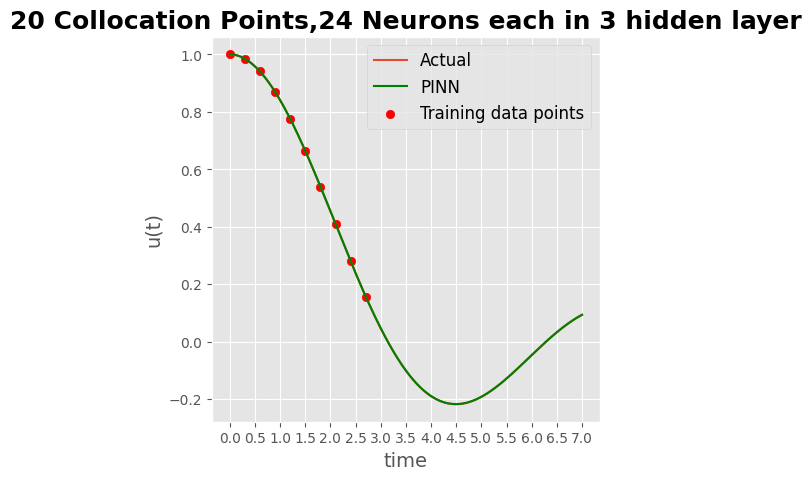

In [ ]:
create_graph_1(20,24,3,x,x_data,y,y_data,y_pred)

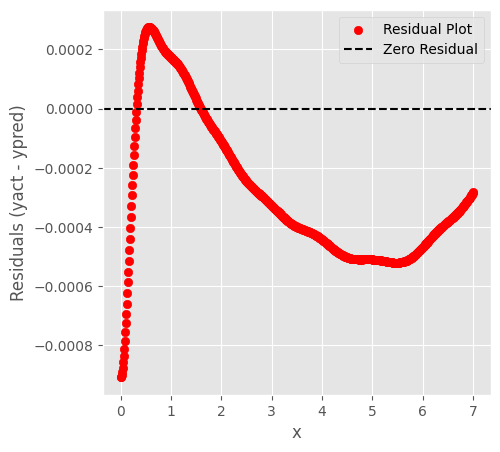

In [ ]:
create_graph_2(x,y_pred)

<h1>4.2 Nh = 5, N = 24, Nc= 20</h1>

In [ ]:
model = create_pinn_model(5,24,20)

Epochs = 0 of 20000, Loss = 5.8446e-01
Epochs = 1000 of 20000, Loss = 1.1396e-02
Epochs = 2000 of 20000, Loss = 5.6505e-04
Epochs = 3000 of 20000, Loss = 6.9745e-05
Epochs = 4000 of 20000, Loss = 3.1520e-05
Epochs = 5000 of 20000, Loss = 1.4292e-05
Epochs = 6000 of 20000, Loss = 3.7823e-06
Epochs = 7000 of 20000, Loss = 6.9493e-07
Epochs = 8000 of 20000, Loss = 1.6421e-07
Epochs = 9000 of 20000, Loss = 1.3305e-07
Epochs = 10000 of 20000, Loss = 5.6371e-04
Epochs = 11000 of 20000, Loss = 4.0131e-06
Epochs = 12000 of 20000, Loss = 3.3639e-05
Epoch 12225: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 13000 of 20000, Loss = 9.4444e-08
Epoch 13226: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 14000 of 20000, Loss = 9.0888e-08
Epoch 14227: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 15000 of 20000, Loss = 9.0499e-08
Epoch 15228: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 16000 of 20000, Loss = 9.0467e-08
Epoch 16229: reducing learning rat

In [ ]:
model.eval()
x = np.linspace(0, 7, 700).reshape(-1, 1)
y = solution(x).reshape(-1, 1)
x_data, y_data, x_physics = create_training_points(20)
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

4.652337317941582e-11


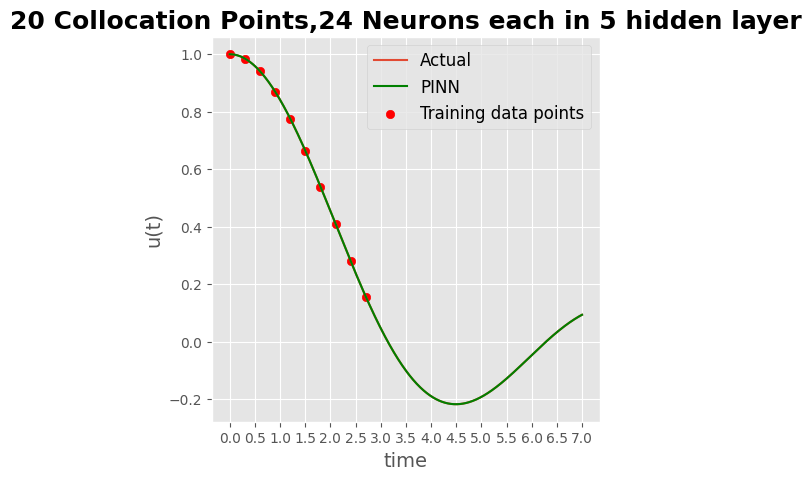

In [ ]:
create_graph_1(20,24,5,x,x_data,y,y_data,y_pred)

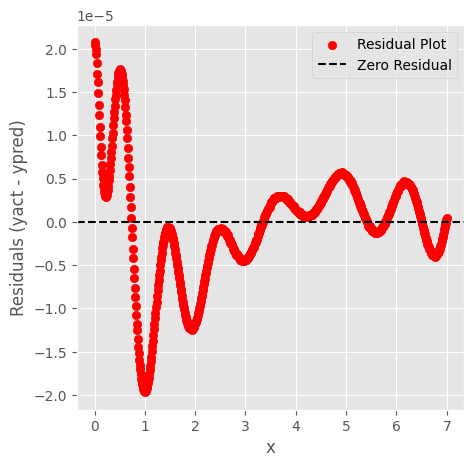

In [ ]:
create_graph_2(x,y_pred)

<h1>4.3 Conclusion</h1>

24 Neurons, 20 Collocation Points:

<ul>
<li>1 Hidden Layer: 2.7053212988187934e-09</li>
<li>3 Hidden Layer: 1.4546934787238253e-07</li>
<li>5 Hidden Layer: 4.652337317941582e-11</li>
</ul>

Therefore, 5 hidden layers seems to the better option. So we'll continue with 5 hidden layers.

<h1>Best Possible Architecture</h1>

1.   Number Of Collocation Points - 20
2.   Number Of Neurons in Each Layer - 24
3.   Number Of Hidden Layers - 5

<b>Error - 4.652337317941582e-11</b>



<h1>5. New Trainable Parameter</h1>

<p> Till Now the combined loss function was loss = loss_p + loss_d where loss_p
denotes physical loss (collocation points) and loss_d denotes MSE loss (training points).</p>

<p> What we can do is introduce a trainable parameter k such that the new loss function is loss = k*loss_p + loss_d, that is we are varying the weight given to physical loss to determine how much importance it should be given.</p>

In [ ]:
x = np.linspace(0, 7, 700).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)

x_data = x[0:300:30] #Reducing the training points
y_data = y[0:300:30]

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

x_physics = torch.linspace(0, 7, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1) #Collocation Points

In [ ]:
EPOCHS = 20000
LR = 3e-3

k = nn.Parameter(torch.tensor(1.0)) #Trainable Parameter
model = NeuralNetwork(hidden_layers=5, hidden_nodes=24)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()
k_values = []
losses = []

k_range = torch.linspace(0.1,2.0,20)

for k_value in k_range:
    k.data.fill_(k_value)  # Set the current k value

    for epoch in range(EPOCHS):
        optim.zero_grad()

        # Compute the "data loss"
        y_pred = model(x_data)
        loss_y = data_loss(y_pred, y_data)

        # Compute the Derivates of the model WRT inputs
        u   = model(x_physics)
        du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
        ddu = ag.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]

        # BC condition on x=0
        loss_y=loss_y + 0.01*(du[0]**2)

        # Compute the physics loss with k
        physics = x_physics * ddu + 2 * du + u * x_physics
        loss_f = torch.mean(physics**2)

        # Backpropagate joint loss
        loss = loss_y + k*loss_f
        loss.backward()
        optim.step()
        scheduler.step(loss)

    # Track the loss and the corresponding k value
    k_values.append(k_value)
    losses.append(loss.item())

# Find the k value with the lowest loss
best_k = k_values[losses.index(min(losses))]

print("Best k:", best_k)
print("Lowest loss:", min(losses))

Epoch 13952: reducing learning rate of group 0 to 3.0000e-04.
Epoch 14953: reducing learning rate of group 0 to 3.0000e-05.
Epoch 15954: reducing learning rate of group 0 to 3.0000e-06.
Epoch 16955: reducing learning rate of group 0 to 3.0000e-07.
Epoch 17956: reducing learning rate of group 0 to 3.0000e-08.
Epoch 18957: reducing learning rate of group 0 to 3.0000e-09.
Best k: tensor(0.1000)
Lowest loss: 3.314839602808206e-07





<p>Therefore k = 0.1 gives the lowest error. We can test this on our model and find the error.</p>

<h1>6. Final Model </h1>

<ul>
<li> Neurons: 24 </li>
<li> Hidden Layers: 5</li>
<li> Collocation Points: 20</li>
<li> k = 0.1 </li>
</ul>

Let's test this hyperparameters and calculate the final error.

In [ ]:
x = np.linspace(0, 7, 700).reshape(-1, 1)  #Training Points
y = solution(x).reshape(-1, 1)

x_data = x[0:300:30] #Reducing the training points
y_data = y[0:300:30]

x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

x_physics = torch.linspace(0, 7, 20, requires_grad=True, dtype=torch.float32).reshape(-1, 1) #Collocation Points

In [ ]:
EPOCHS = 20000
LR = 3e-3

model = NeuralNetwork(hidden_layers=5, hidden_nodes=24)
optim = torch.optim.Adam(model.parameters(),lr=LR)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=1000, verbose=True)
data_loss = nn.MSELoss()

for epoch in range(EPOCHS):
    optim.zero_grad()

    # Compute the "data loss"
    y_pred = model(x_data)
    loss_y = data_loss(y_pred, y_data)

    # Compute the Derivates of the model WRT inputs
    u   = model(x_physics)
    du  = ag.grad(u, x_physics, torch.ones_like(u), create_graph=True)[0]
    ddu = ag.grad(du,  x_physics, torch.ones_like(du),  create_graph=True)[0]

    # BC condition on x=0
    loss_y=loss_y + 0.01*(du[0]**2)

    # Compute the physics loss
    physics = x_physics*ddu + 2*du + u*x_physics
    loss_f = torch.mean(physics**2)

    # backpropagate joint loss
    loss = loss_y + 0.1*loss_f # add two loss terms together with more weight to physics loss
    loss.backward()
    optim.step()
    scheduler.step(loss)

    if epoch % 1000 == 0:
        print(f"Epochs = {epoch} of {EPOCHS}, Loss = {float(loss):.4e}")

Epochs = 0 of 20000, Loss = 5.9322e-01
Epochs = 1000 of 20000, Loss = 1.1473e-03
Epochs = 2000 of 20000, Loss = 2.6375e-04
Epochs = 3000 of 20000, Loss = 5.0462e-05
Epochs = 4000 of 20000, Loss = 7.8908e-06
Epochs = 5000 of 20000, Loss = 2.7226e-06
Epochs = 6000 of 20000, Loss = 3.8500e-07
Epochs = 7000 of 20000, Loss = 1.2763e-06
Epoch 07909: reducing learning rate of group 0 to 3.0000e-04.
Epochs = 8000 of 20000, Loss = 2.5397e-07
Epoch 08910: reducing learning rate of group 0 to 3.0000e-05.
Epochs = 9000 of 20000, Loss = 2.3425e-07
Epoch 09911: reducing learning rate of group 0 to 3.0000e-06.
Epochs = 10000 of 20000, Loss = 2.3225e-07
Epoch 10912: reducing learning rate of group 0 to 3.0000e-07.
Epochs = 11000 of 20000, Loss = 2.3207e-07
Epoch 11913: reducing learning rate of group 0 to 3.0000e-08.
Epochs = 12000 of 20000, Loss = 2.3201e-07
Epoch 12914: reducing learning rate of group 0 to 3.0000e-09.
Epochs = 13000 of 20000, Loss = 2.3204e-07
Epochs = 14000 of 20000, Loss = 2.3204e

In [ ]:
model.eval()
y_pred = model(torch.tensor(x, dtype = torch.float32).reshape(-1,1))
y_pred = y_pred.detach().cpu().numpy().reshape(-1,1)

In [ ]:
squared_error = (y - y_pred)**2
loss_pred = np.mean(squared_error)
print(loss_pred.item())

4.924741613711902e-10


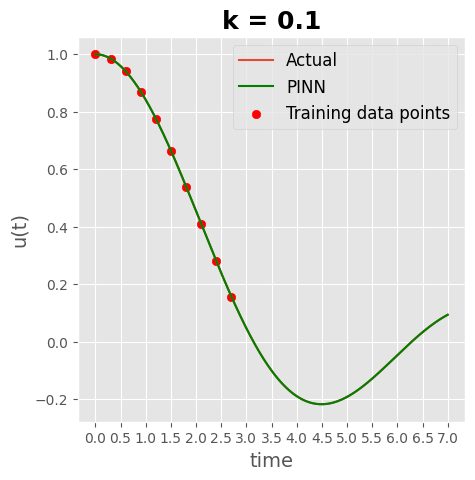

In [ ]:
title_font = {
    "fontsize" : 18,
    "fontweight": "bold"
}

plt.figure(figsize=(5, 5))
plt.style.use("ggplot")
plt.xticks(np.arange(0, 7.5, step=0.5))
plt.title("k = 0.1", title_font)
plt.plot(x, y, label="Actual")
plt.xlabel("time", fontsize=14)
plt.plot(x, y_pred, label="PINN", c="g")
plt.ylabel("u(t)", fontsize=14)
plt.scatter(x_data.reshape(-1,), y_data.reshape(-1,), c="r", label="Training data points")
plt.legend(fontsize="large")
plt.show()

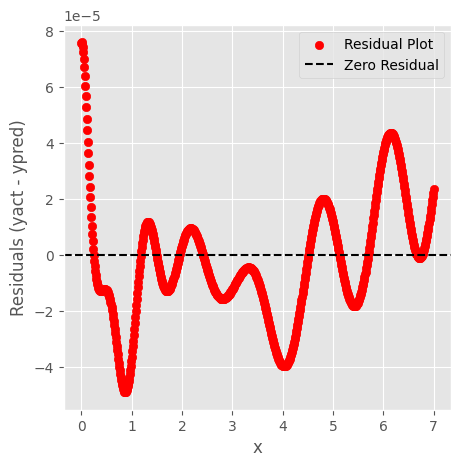

In [ ]:
residuals = y - y_pred
plt.figure(figsize=(5, 5))
plt.scatter(x, residuals, color='r', label='Residual Plot')
plt.axhline(y=0, color='k', linestyle='--', label='Zero Residual')
plt.xlabel('x')
plt.ylabel('Residuals (yact - ypred)')
plt.legend()
plt.show()

<b>Research Paper's Error: 3.16 x 10^-9</b>
<br>
<b>Our Final Error: 4.92 x 10^-10</b>
